#### Install SAM-2

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -e .
!pip install -q -U google-generativeai
!pip install jupyter_bbox_widget

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1057, done.
remote: Counting objects: 100% (412/412), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1057 (delta 271), reused 246 (delta 246), pack-reused 645 (from 2)
Receiving objects: 100% (1057/1057), 121.74 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (384/384), done.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00


#### Download SAM 2.1 checkpoints

In [ ]:
!mkdir -p /content/sam2.1_checkpoints
!wget -q sam2_hiera_tiny.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt -P /content/sam2.1_checkpoints
!wget -q sam2_hiera_small.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt -P /content/sam2.1_checkpoints
!wget -q sam2_hiera_base_plus.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt -P /content/sam2.1_checkpoints
!wget -q sam2_hiera_large.pt https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt -P /content/sam2.1_checkpoints

#### Import libraries

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from google.colab import output
output.enable_custom_widget_manager()
from jupyter_bbox_widget import BBoxWidget

from google.colab import auth
auth.authenticate_user()

import PIL
from google.colab import userdata
from matplotlib import pyplot as plt
import google.generativeai as genai
import torch
import base64
import cv2
import re
import json
import torchvision
import numpy as np
import vertexai
from vertexai.preview.vision_models import (
    ControlReferenceImage,
    Image,
    ImageGenerationModel,
    MaskReferenceImage,
    RawReferenceImage,
)

#### Configure Gemini API key and GCP Project ID

In [ ]:
API_KEY = userdata.get('gemini')
genai.configure(api_key=API_KEY)
model = genai.GenerativeModel(model_name='gemini-1.5-pro')

GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')

#### Utility functions: Parse response and draw bounding boxes

In [ ]:
def parse_bounding_box(response):
    bounding_boxes = re.findall(r'\[(\d+,\s*\d+,\s*\d+,\s*\d+,\s*[\w\s]+)\]', response)

    # Convert each group into a list of integers and labels.
    parsed_boxes = []
    for box in bounding_boxes:
        parts = box.split(',')
        numbers = list(map(int, parts[:-1]))
        label = parts[-1].strip()
        parsed_boxes.append((numbers, label))

    # Return the list of bounding boxes with their labels.
    return parsed_boxes


def draw_bounding_boxes(image, bounding_boxes_with_labels):
    label_colors = {}
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image = np.array(image)

    for bounding_box, label in bounding_boxes_with_labels:

        # Normalize the bounding box coordinates
        width, height = image.shape[1], image.shape[0]
        ymin, xmin, ymax, xmax = bounding_box
        x1 = int(xmin / 1000 * width)
        y1 = int(ymin / 1000 * height)
        x2 = int(xmax / 1000 * width)
        y2 = int(ymax / 1000 * height)

        coordinates = [x1, y1, x2, y2]

        if label not in label_colors:
            color = np.random.randint(0, 256, (3,)).tolist()
            label_colors[label] = color
        else:
            color = label_colors[label]

        color = (254, 4, 141)

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2
        box_thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]

        text_bg_x1 = x1
        text_bg_y1 = y1 - text_size[1] - 5
        text_bg_x2 = x1 + text_size[0] + 8
        text_bg_y2 = y1


        cv2.rectangle(image, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
        cv2.putText(image, label, (x1 + 2, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, box_thickness)

    image = PIL.Image.fromarray(image)
    return image, coordinates

#### Pass input image and prompt

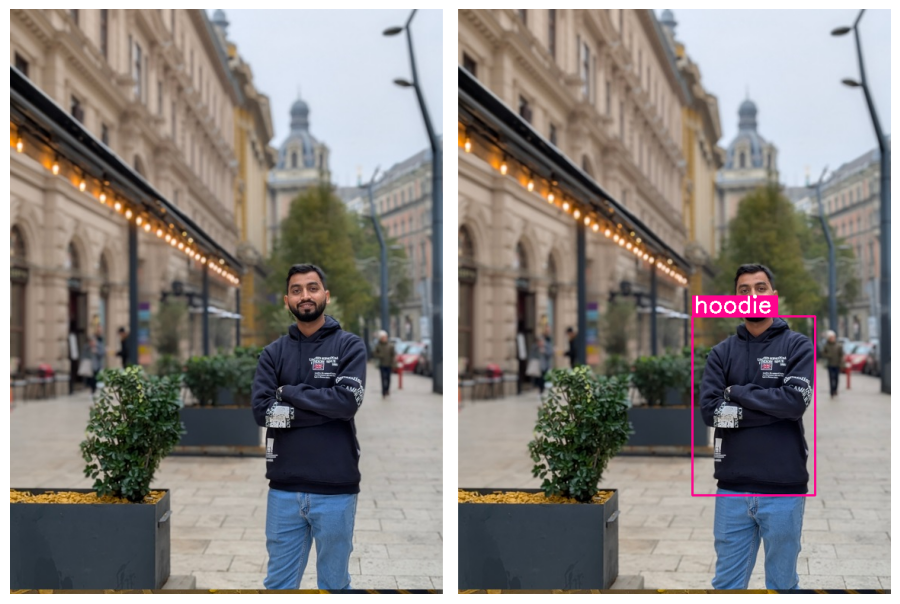

In [ ]:
input_image = 'image.jpg' # @param {type : 'string'}
object_to_detect = 'hoodie' # @param {type: 'string'}
img = PIL.Image.open(input_image)

response = model.generate_content([
    img,
    (
        f"Detect 2d bounding box of {object_to_detect} and return it in the below format"
        "list. \n [ymin, xmin, ymax, xmax, object_name]. If there are more than one object, return separate lists for each object"
    ),
])

result = response.text

bounding_box = parse_bounding_box(result)
output, coordinates = draw_bounding_boxes(img, bounding_box)
output_image = f'detect_{input_image}'
output.save(output_image)

img_array = np.array(img)
output_array = np.array(output)

gap_width = 20
empty_img = np.full((img_array.shape[0], gap_width, img_array.shape[2]), 255, dtype=img_array.dtype)
combined_image = np.hstack((img_array, empty_img, output_array))

fig, axes = plt.subplots(1, 1, figsize=(img_array.shape[1] / 50, img_array.shape[0] / 50))

axes.imshow(combined_image)
axes.axis('off')

plt.show()

#### Draw points within ROI

You can either automatically draw the points using the bounding box generated by Gemini, or manually annotate them.

The more accurate the mask, the better the resulting output by Imagen 3 will be.

In [ ]:
annotation = 'Automatic' # @param ['Automatic', 'Manual']

In [ ]:
captured_points = []

def encode_image(filepath):
  with open(filepath, 'rb') as f:
    image_bytes = f.read()
  encoded = str(base64.b64encode(image_bytes), 'utf-8')
  return "data:image/jpg;base64,"+encoded

def handle_captured_points(points):
    global captured_points
    captured_points = points

def get_roi_points(input_image, annotation):
  global captured_points
  if annotation == 'Automatic':
    image = cv2.imread(input_image)
    x1, y1, x2, y2 = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    centre_x = (x1+x2)//2
    centre_y = (y1+y2)//2

    color = (0, 255, 0)
    radius = 5

    # Draw the points on the image.
    p1 = (centre_x, centre_y)
    p2 = (centre_x, (centre_y+y1)//2)
    p3 = (centre_x, (centre_y+y2)//2)
    p4 = ((centre_x+x1)//2, centre_y)
    p5 = ((centre_x+x2)//2, centre_y)

    points = [p1, p2, p3, p4, p5]

    cv2.circle(image, (centre_x, centre_y), radius, color, -1)
    cv2.circle(image, (centre_x, (centre_y+y1)//2), radius, color, -1)
    cv2.circle(image, (centre_x, (centre_y+y2)//2), radius, color, -1)
    cv2.circle(image, ((centre_x+x1)//2, centre_y), radius, color, -1)
    cv2.circle(image, ((centre_x+x2)//2, centre_y), radius, color, -1)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    roi_output = PIL.Image.fromarray(image)
    roi_output.save(f'roi_point_{input_image}')
    display(roi_output)
    return points
  else:
    widget = BBoxWidget(classes=[object_to_detect])
    widget.image = encode_image(input_image)
    display(widget)
    callback=handle_captured_points
    def on_submit():
            bboxes = widget.bboxes
            if bboxes:
                points = [(box['x'], box['y']) for box in bboxes]
                if callback:
                    callback(points)
            else:
                print("No bounding boxes selected.")

    widget.on_submit(on_submit)
    points = captured_points
    return points

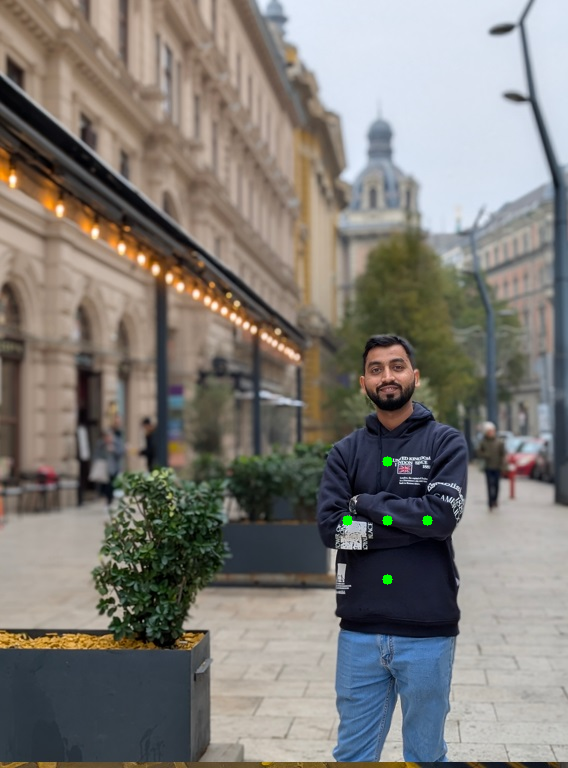

In [ ]:
points = get_roi_points(input_image, annotation=annotation)

In [ ]:
if annotation == 'Manual':
  points = captured_points

#### Load model checkpoint

In [ ]:
sam2_checkpoint = "sam2.1_hiera_small.pt"  # @param ["sam2.1_hiera_tiny.pt", "sam2.1_hiera_small.pt", "sam2.1_hiera_base_plus.pt", "sam2.1_hiera_large.pt"]
model_config = "sam2.1_hiera_s.yaml" # @param ["sam2.1_hiera_t.yaml", "sam2.1_hiera_s.yaml", "sam2.1_hiera_b+.yaml", "sam2.1_hiera_l.yaml"]

sam2_checkpoint = f"/content/sam2.1_checkpoints/{sam2_checkpoint}"

model_config = f"configs/sam2.1/{model_config}"

sam2_model = build_sam2(model_config, sam2_checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)
predictor = SAM2ImagePredictor(sam2_model)


#### Get mask from SAM 2.1

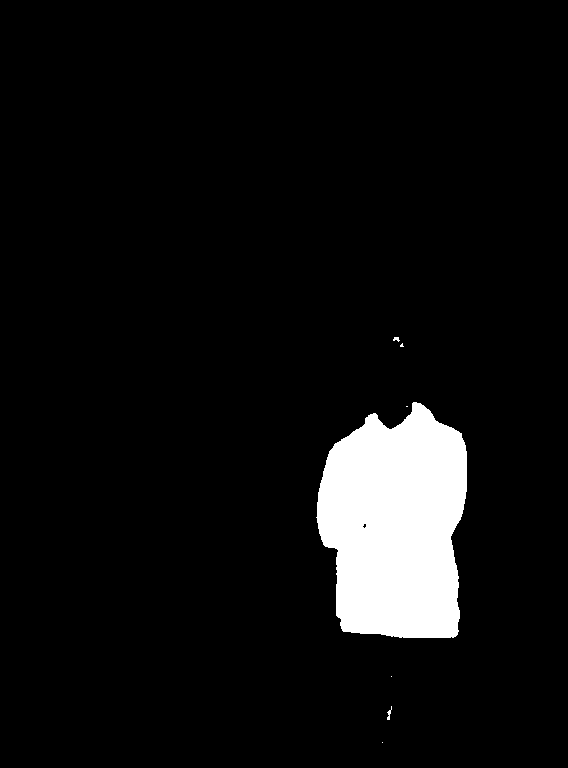

In [ ]:
input_point = np.array([
      [
        point[0],
        point[1]
      ] for point in points
  ])

input_label = np.ones(input_point.shape[0])

predictor.set_image(img)

masks, scores, logits = predictor.predict(
    point_coords = input_point,
    point_labels = input_label,
    multimask_output = False,
)

mask_img = PIL.Image.fromarray((masks[0]*255).astype(np.uint8))
mask_img.save(f"{annotation}_mask_{input_image}")
display(mask_img)

#### Configure Imagen 3 parameters

In [ ]:
mask_file = f"{annotation}_mask_{input_image}"
output_file = f"output_{input_image}"
prompt = "A dark green jacket, waist length, with white shirt inside it" # @param {type: 'string'}

edit_mode = 'inpainting-insert' # @param ['inpainting-insert', 'outpainting', 'inpainting-remove']
mask_mode = 'foreground' # @param ['foreground', 'background']
dilation = 0.01 # @param {type:"slider", min:0, max:1, step:0.01}

#### Generate and inpaint new image using Imagen 3

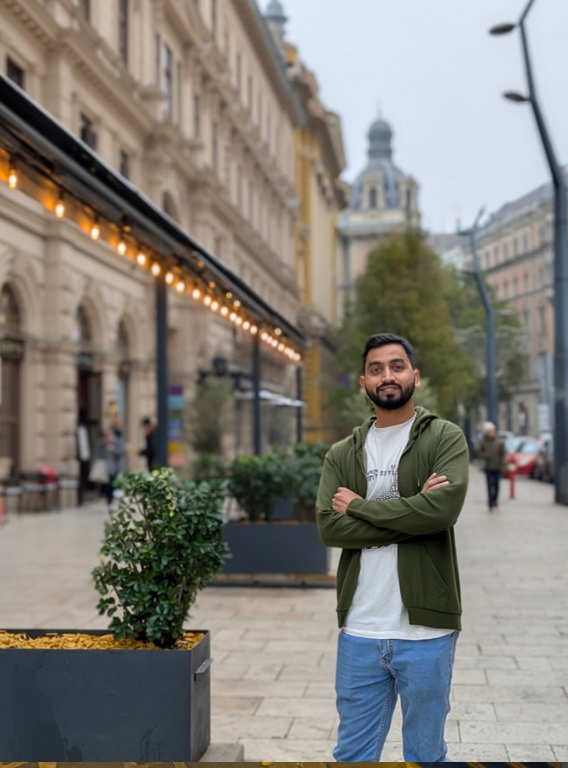

In [ ]:
vertexai.init(project=GCP_PROJECT_ID, location="us-central1")

edit_model = ImageGenerationModel.from_pretrained("imagen-3.0-capability-001")

base_img = Image.load_from_file(location=input_image)
mask_img = Image.load_from_file(location=mask_file)

raw_ref_image = RawReferenceImage(image=base_img, reference_id=0)
mask_ref_image = MaskReferenceImage(
    reference_id=1, image=mask_img, mask_mode=mask_mode, dilation=dilation
)

edited_image = edit_model.edit_image(
    prompt=prompt,
    edit_mode=edit_mode,
    reference_images=[raw_ref_image, mask_ref_image],
    number_of_images=1,
    safety_filter_level="block_some",
    person_generation="allow_adult",
)

edited_image[0].save(output_file)
edited_image[0].show()